In [1]:
!pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.24-cp36-none-any.whl size=6506 sha256=9c356cbb8224cb5a43f3dea80c29b17da335d56df0cee454cda074f4c9e80496
  Stored in directory: /root/.cache/pip/wheels/a9/1a/d2/1264c7b2ededd8fab16491e873fb037693d6f8c93f96b72ffa
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.17-cp36-none-any.whl size=6911 sha256=26046650f243a38d69eddcfc667c4097f0a1b351f63f8441ce2a40d836070590
  Stored in directory: /root/.cache/pip/wheels/32/c3/be/1397a4eb670d84d3ae81882efe3b1e6c214291cbc696c24079
  Created wheel for compress-json: filename=compress_json-1.0.4-cp36-none-any.whl size=4586 sha256=47db774a8d478240c3d3172fabe9c27dea34eb603feb0fd5505d5d0cd35e6248
  Stored in directory: /root/.cache/pip/wheels/83/ec/21/51460dd508e4a152c0643946c21fae84eb3391171164d35745
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [2]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Conv1D,Conv2D,MaxPool2D, GlobalMaxPooling1D, Dense, Reshape, Dropout, Flatten, MaxPooling1D, Input, Concatenate, LSTM, Bidirectional
from keras.models import load_model, Sequential,Model
from keras.layers.merge import concatenate
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Packages for modeling
import keras
from keras import models
from keras import layers
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.externals import joblib

import matplotlib.pyplot as plt
from plot_keras_history import plot_history
print (keras.__version__)

2.4.3


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Pre-Process

In [5]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary to create word vector
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 128  # Size of the batches used in the mini-batch gradient descent

In [6]:
df = pd.read_excel(r'/content/drive/My Drive/ISS/EBA5004/PLP Project/Data/full_reviews.xlsx')

In [7]:
df = df[['classification', 'review_text']]

In [9]:
df.drop(df[df['classification']=='Neutral'].index, inplace=True)

In [10]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 

In [11]:
df['review_text'] = df['review_text'].map(lambda x: re.sub('[^A-Za-z\ 0-9 ]+', '', x))
df['review_text'] = df['review_text'].map(lambda x: re.sub('[,\.!?]', '', x))
df['review_text'] = df['review_text'].map(lambda x: x.lower())
df['review_text'] = df['review_text'].apply(remove_stopwords)
df.head()

,classification,review_text
0,Positive,stayed ascott nights took bedroom apartment st...
1,Positive,great service overall prime location excellent...
2,Positive,location quite good bringing family children r...
3,Positive,positive location people reception negative re...
4,Positive,apartment clean relatively new family five sta...


In [12]:
# df.isnull().sum()
# df.dropna(inplace=True)
# df["classification"].value_counts()
# df = df.reset_index(drop=True)
df = df.reindex(np.random.permutation(df.index))  
df.head()

,classification,review_text
87872,Positive,huge room great location perfect place staycat...
73751,Positive,exceptional positive rest negative no balcony
81431,Positive,fabulous positive good location needs negative...
88460,Positive,positive good location wonderful suite friendl...
93493,Positive,positive ive staying citadines soi8 several ye...


# Prepare Training and Tesing

In [13]:
# Split train & test
text_train, text_test, y_train, y_test = train_test_split(df['review_text'], df["classification"], test_size=0.1, random_state=37, stratify=df["classification"])
print('# Train data samples:', text_train.shape[0])
print('# Test data samples:', text_test.shape[0])
# assert X_train.shape[0] == y_train.shape[0]
# assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 74115
# Test data samples: 8236


In [14]:
from collections import Counter
Counter(y_train)

Counter({'Negative': 6056, 'Positive': 68059})

In [58]:
max(len(x) for x in X_train)

827

In [15]:
#tokenization
tokenizer = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tokenizer.fit_on_texts(text_train)
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set
class_num = 2
EPOCH = 15
print('vocabubary size:',vocab_size)
print('max length text:',maxlen)

#Padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#embedding dimension should align with the GLOVE
embedding_dim = 100
vocab_size = len(word_index) + 1

GLOVE_6B_100D_PATH ="/content/drive/My Drive/ISS/EBA5004/3. TPML/Day 2/Workshop/glove.6B.100d.txt"
encoding="utf-8"
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    embeddings_index = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)

vocabubary size: 44912
max length text: 827
0.550498753117207


In [57]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
#create class weight dict for unbanlanced dataset
#If 'balanced', class weights will be given by n_samples / (n_classes * np.bincount(y)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_d = dict(enumerate(class_weights))

In [18]:
##onehot encoding for y
def categoricalList2Onehot(listOfClasses):
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(listOfClasses)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

y_train_onehot = categoricalList2Onehot(y_train)
y_train_onehot.shape
y_test_onehot = categoricalList2Onehot(y_test)
y_test_onehot.shape

(8236, 2)

# CNN

## Shallow CNN

In [59]:
# Shallow CNN
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,trainable=False,weights=[embedding_matrix]))
model.add(Conv1D(512, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(class_num, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 827, 100)          4491200   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 825, 512)          154112    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 1026      
Total params: 4,646,338
Trainable params: 155,138
Non-trainable params: 4,491,200
_________________________________________________________________


Epoch 1/15
580/580 [==============================] - 29s 50ms/step - loss: 0.2985 - accuracy: 0.8731 - val_loss: 0.1752 - val_accuracy: 0.9298
Epoch 2/15
580/580 [==============================] - 29s 50ms/step - loss: 0.2109 - accuracy: 0.9119 - val_loss: 0.1322 - val_accuracy: 0.9483
Epoch 3/15
580/580 [==============================] - 29s 51ms/step - loss: 0.1557 - accuracy: 0.9359 - val_loss: 0.1138 - val_accuracy: 0.9557
Epoch 4/15
580/580 [==============================] - 29s 51ms/step - loss: 0.1204 - accuracy: 0.9492 - val_loss: 0.1814 - val_accuracy: 0.9292
Epoch 5/15
580/580 [==============================] - 30s 51ms/step - loss: 0.0946 - accuracy: 0.9620 - val_loss: 0.2805 - val_accuracy: 0.8966
Epoch 6/15
580/580 [==============================] - 30s 51ms/step - loss: 0.0641 - accuracy: 0.9734 - val_loss: 0.3397 - val_accuracy: 0.8849
Epoch 7/15
580/580 [==============================] - 30s 51ms/step - loss: 0.0448 - accuracy: 0.9814 - val_loss: 0.1596 - val_accuracy:

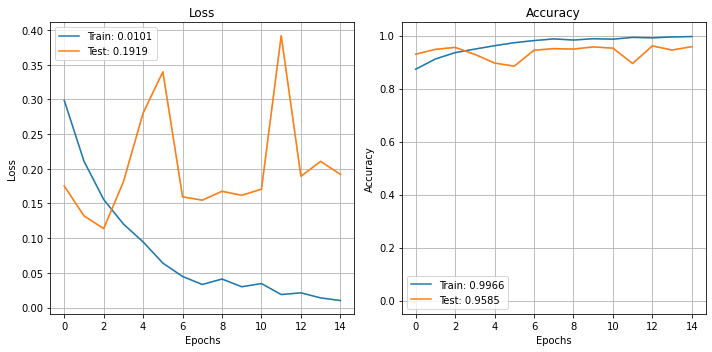

In [60]:
#train the model

hist = model.fit(X_train, y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=15,
                    verbose=True,
                    validation_data=(X_test, y_test_onehot),
                    batch_size=128).history

loss, accuracy = model.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

In [61]:
y_pred = model.predict(X_test)
matrix = classification_report(np.argmax(y_test_onehot, axis=1), np.argmax(y_pred, axis=1))
print(matrix)

              precision    recall  f1-score   support

           0       0.76      0.71      0.74       673
           1       0.97      0.98      0.98      7563

    accuracy                           0.96      8236
   macro avg       0.87      0.85      0.86      8236
weighted avg       0.96      0.96      0.96      8236



In [63]:
from keras.models import Sequential, save_model, load_model
filepath = r'/content/drive/My Drive/ISS/EBA5004/PLP Project/cnn_model.hdf5'
save_model(model, filepath)

In [64]:
model_x = load_model(filepath)

In [71]:
text_test.iloc[0]

'brilliant location lots options eat walking distance excellent professional staff comfortable stay love every bit wanna come family business place disclaimer no restaurants available hotel thats selection criteria'

In [73]:
X_test[0]

array([ 763,    5,  180,  219,  312,   69,   84,   27,  283,    3,   18,
         10,  120,  126,   61, 2585,  117,   72,  168,   21,   22,   49,
        125,    2,  496,  378, 7741,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Shallow CNN with dropout

In [28]:
# Modify Shallow CNN with dropout Layer

model_dp = Sequential()
model_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model_dp.add(Conv1D(512, 3, activation='relu'))
model_dp.add(GlobalMaxPooling1D())
model_dp.add(Dense(64, activation='relu'))
model_dp.add(Dropout(0.2))
model_dp.add(Dense(class_num, activation='softmax'))
model_dp.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_dp.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 827, 100)          4491200   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 825, 512)          154112    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 4,678,274
Trainable params: 187,074
Non-trainable params: 4,491,200
______________________________________

Epoch 1/15
580/580 [==============================] - 28s 49ms/step - loss: 0.3157 - accuracy: 0.8616 - val_loss: 0.2314 - val_accuracy: 0.9110
Epoch 2/15
580/580 [==============================] - 28s 49ms/step - loss: 0.2195 - accuracy: 0.9094 - val_loss: 0.1794 - val_accuracy: 0.9286
Epoch 3/15
580/580 [==============================] - 29s 50ms/step - loss: 0.1802 - accuracy: 0.9248 - val_loss: 0.1851 - val_accuracy: 0.9201
Epoch 4/15
580/580 [==============================] - 29s 50ms/step - loss: 0.1463 - accuracy: 0.9369 - val_loss: 0.2452 - val_accuracy: 0.9014
Epoch 5/15
580/580 [==============================] - 29s 50ms/step - loss: 0.1183 - accuracy: 0.9488 - val_loss: 0.1329 - val_accuracy: 0.9469
Epoch 6/15
580/580 [==============================] - 29s 50ms/step - loss: 0.0954 - accuracy: 0.9583 - val_loss: 0.1398 - val_accuracy: 0.9466
Epoch 7/15
580/580 [==============================] - 29s 50ms/step - loss: 0.0785 - accuracy: 0.9656 - val_loss: 0.1509 - val_accuracy:

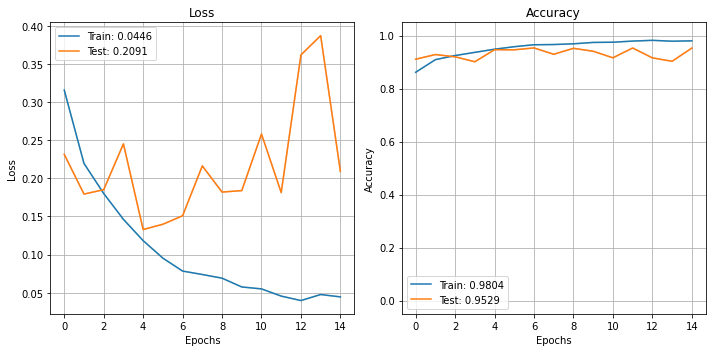

In [29]:
#train the model

hist_dp = model_dp.fit(X_train, y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=EPOCH,
                    verbose=True,
                    validation_data=(X_test, y_test_onehot),
                    batch_size=BATCH_SIZE).history

loss, accuracy = model_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_dp)

In [30]:
y_pred = model_dp.predict(X_test)
matrix = classification_report(np.argmax(y_test_onehot, axis=1), np.argmax(y_pred, axis=1))
print(matrix)

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       673
           1       0.98      0.97      0.97      7563

    accuracy                           0.95      8236
   macro avg       0.84      0.86      0.85      8236
weighted avg       0.95      0.95      0.95      8236



## Deep CNN

In [32]:
##Deep CNN 
# define the model
from keras.layers.merge import concatenate

def define_model(length, vocab_size,embedding_dim):
	# channel 1
	inputs1 = Input(shape=(length,))
	embedding1 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs1)
	conv1 = Conv1D(filters=128, kernel_size=2, activation='relu')(embedding1)
	drop1 = Dropout(0.5)(conv1)
	pool1 = MaxPooling1D(pool_size=2)(drop1)
	flat1 = Flatten()(pool1)
	# channel 2
	inputs2 = Input(shape=(length,))
	embedding2 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs2)
	conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding2)
	drop2 = Dropout(0.5)(conv2)
	pool2 = MaxPooling1D(pool_size=2)(drop2)
	flat2 = Flatten()(pool2)
	# channel 3
	inputs3 = Input(shape=(length,))
	embedding3 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs3)
	conv3 = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding3)
	drop3 = Dropout(0.5)(conv3)
	pool3 = MaxPooling1D(pool_size=2)(drop3)
	flat3 = Flatten()(pool3)
	# merge
	merged = concatenate([flat1, flat2, flat3])
	# interpretation
	dense1 = Dense(64, activation='relu')(merged)
	outputs = Dense(class_num, activation='softmax')(dense1)
	model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# summarize
	print(model.summary())
	return model

model_deep = define_model(maxlen,vocab_size,embedding_dim)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 827)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 827)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 827)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 827, 100)     4491200     input_4[0][0]                    
_______________________________________________________________________________________

Epoch 1/15
580/580 [==============================] - 38s 65ms/step - loss: 0.3607 - accuracy: 0.8448 - val_loss: 0.3205 - val_accuracy: 0.8748
Epoch 2/15
580/580 [==============================] - 37s 64ms/step - loss: 0.2589 - accuracy: 0.8901 - val_loss: 0.2873 - val_accuracy: 0.8806
Epoch 3/15
580/580 [==============================] - 37s 64ms/step - loss: 0.2229 - accuracy: 0.9061 - val_loss: 0.2199 - val_accuracy: 0.9075
Epoch 4/15
580/580 [==============================] - 37s 64ms/step - loss: 0.1917 - accuracy: 0.9175 - val_loss: 0.1744 - val_accuracy: 0.9297
Epoch 5/15
580/580 [==============================] - 37s 65ms/step - loss: 0.1672 - accuracy: 0.9269 - val_loss: 0.1763 - val_accuracy: 0.9321
Epoch 6/15
580/580 [==============================] - 37s 64ms/step - loss: 0.1510 - accuracy: 0.9347 - val_loss: 0.1894 - val_accuracy: 0.9239
Epoch 7/15
580/580 [==============================] - 38s 65ms/step - loss: 0.1314 - accuracy: 0.9422 - val_loss: 0.1987 - val_accuracy:

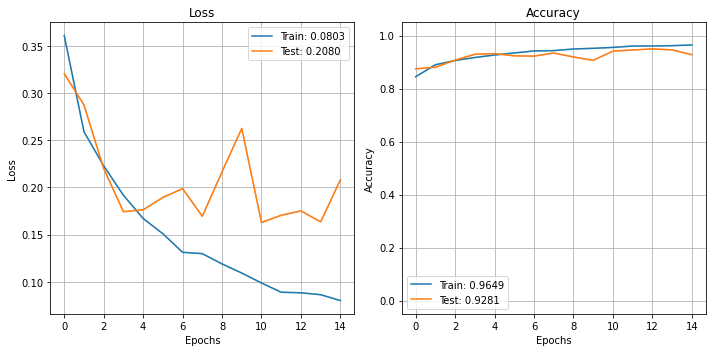

In [33]:
#train the model

hist_deep = model_deep.fit([X_train,X_train,X_train], y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=EPOCH,
                    verbose=True,
                    validation_data=([X_test,X_test,X_test], y_test_onehot),
                    batch_size=BATCH_SIZE).history

loss, accuracy = model_deep.evaluate([X_train,X_train,X_train], y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_deep.evaluate([X_test,X_test,X_test], y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_deep)

In [34]:
y_pred = model_deep.predict([X_test,X_test,X_test])
matrix = classification_report(np.argmax(y_test_onehot, axis=1), np.argmax(y_pred, axis=1))
print(matrix)

              precision    recall  f1-score   support

           0       0.54      0.85      0.66       673
           1       0.99      0.93      0.96      7563

    accuracy                           0.93      8236
   macro avg       0.76      0.89      0.81      8236
weighted avg       0.95      0.93      0.94      8236



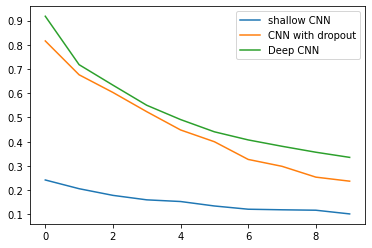

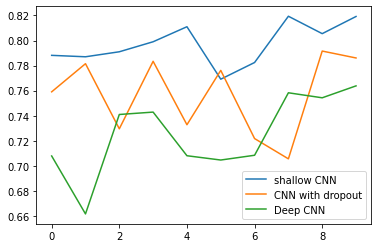

In [ ]:
#Compare all the models

plt.plot(hist['loss'], label='Shallow CNN')
plt.plot(hist_dp['loss'], label='CNN with dropout')
plt.plot(hist_deep['loss'], label='Deep CNN')
plt.legend(loc='upper right')
plt.show()

plt.plot(hist['val_accuracy'], label='shallow CNN')
plt.plot(hist_dp['val_accuracy'], label='CNN with dropout')
plt.plot(hist_deep['val_accuracy'], label='Deep CNN')
plt.legend(loc='lower right')
plt.show()

# BiLSTM

In [47]:
#Define the BiLSTM model with output Dropout
##############################################
model_out_dp = Sequential()
model_out_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model_out_dp.add(Bidirectional(LSTM(64)))
#output Dropout
model_out_dp.add(Dropout(0.5))
model_out_dp.add(Dense(class_num, activation='softmax'))

# try using different optimizers and different optimizer configs
model_out_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_out_dp.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 827, 100)          4491200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 258       
Total params: 4,575,938
Trainable params: 84,738
Non-trainable params: 4,491,200
_________________________________________________________________


In [50]:
hist_dp = model_out_dp.fit(X_train, y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=EPOCH,
                    verbose=True,
                    validation_data=(X_test, y_test_onehot),
                    batch_size=BATCH_SIZE).history

Epoch 1/15
580/580 [==============================] - 49s 84ms/step - loss: 0.1360 - accuracy: 0.9439 - val_loss: 0.1745 - val_accuracy: 0.9341
Epoch 2/15
580/580 [==============================] - 49s 84ms/step - loss: 0.1284 - accuracy: 0.9471 - val_loss: 0.1854 - val_accuracy: 0.9279
Epoch 3/15
580/580 [==============================] - 49s 84ms/step - loss: 0.1227 - accuracy: 0.9488 - val_loss: 0.1688 - val_accuracy: 0.9365
Epoch 4/15
580/580 [==============================] - 48s 84ms/step - loss: 0.1147 - accuracy: 0.9531 - val_loss: 0.2016 - val_accuracy: 0.9292
Epoch 5/15
580/580 [==============================] - 49s 84ms/step - loss: 0.1220 - accuracy: 0.9489 - val_loss: 0.1523 - val_accuracy: 0.9424
Epoch 6/15
580/580 [==============================] - 53s 91ms/step - loss: 0.1088 - accuracy: 0.9556 - val_loss: 0.1739 - val_accuracy: 0.9386
Epoch 7/15
580/580 [==============================] - 53s 92ms/step - loss: 0.1043 - accuracy: 0.9569 - val_loss: 0.1690 - val_accuracy:

2317/2317 [==============================] - 66s 29ms/step - loss: 0.0681 - accuracy: 0.9764
Training Accuracy: 0.9764
Testing Accuracy:  0.9478


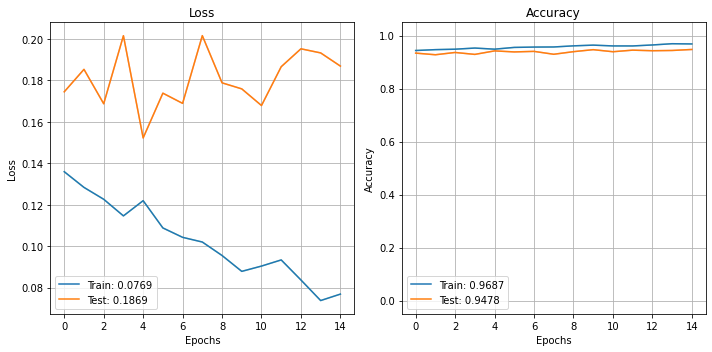

In [53]:
# 30 epochs
loss, accuracy = model_out_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_out_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_dp)

In [ ]:
y_pred = model_out_dp.predict(X_test)
matrix = classification_report(np.argmax(y_test_onehot, axis=1), np.argmax(y_pred, axis=1))
print(matrix)

In [ ]:
#recurent_dropout
###############################################################################
model_rec_dp = Sequential()
model_rec_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#recurent_dropout
model_rec_dp.add(Bidirectional(LSTM(64,recurrent_dropout=0.5)))
model_rec_dp.add(Dense(3, activation='softmax'))

# try using different optimizers and different optimizer configs
model_rec_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_rec_dp.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 1048, 100)         3310600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 387       
Total params: 3,395,467
Trainable params: 84,867
Non-trainable params: 3,310,600
_________________________________________________________________


In [ ]:
#Train the model
batch_size = 128

print('Train...')
hist_rec_dp = model_rec_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=10,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_rec_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_rec_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_rec_dp)

In [ ]:
#Combain all dropout
##############################################################################
model_all_dp = Sequential()
model_all_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#Input Dropout and rec Dropout
model_all_dp.add(Bidirectional(LSTM(64,dropout=0.5,recurrent_dropout=0.5)))
#output Dropout
model_all_dp.add(Dropout(0.5))
model_all_dp.add(Dense(3, activation='softmax'))
# try using different optimizers and different optimizer configs
model_all_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_all_dp.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 1048, 100)         3310600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 387       
Total params: 3,395,467
Trainable params: 84,867
Non-trainable params: 3,310,600
_________________________________________________________________


In [ ]:
#Train the model
batch_size = 64

print('Train...')
hist_all_dp = model_all_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=10,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_all_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_all_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_all_dp)

In [ ]:
#Compare all the models

plt.plot(hist_all_dp['loss'], label='all')
plt.plot(hist_rec_dp['loss'], label='rec')
plt.plot(hist_input_dp['loss'], label='input')
plt.plot(hist_out_dp['loss'], label='output')
plt.legend(loc='upper right')
plt.show()

plt.plot(hist_all_dp['val_accuracy'], label='all')
plt.plot(hist_rec_dp['val_accuracy'], label='rec')
plt.plot(hist_input_dp['val_accuracy'], label='input')
plt.plot(hist_out_dp['val_accuracy'], label='output')
plt.legend(loc='lower right')
plt.show()

# Transformer

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [36]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [37]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [38]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [20]:
# vocab_size = 20000  # Only consider the top 20k words
# vocab_size = len(word_index) + 1
# maxlen = 1048  # Only consider the first 200 words of each movie review
# maxlen = max(len(x) for x in X_train) # longest text in train set

In [39]:
y_train_transform = y_train.replace(['Positive','Negative'],[1,0])

In [40]:
y_test_transform = y_test.replace(['Positive','Negative'],[1,0])

In [41]:
embed_dim = 100  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 100  # Hidden layer size in feed forward network inside transformer

# Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False)

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [42]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train, 
    y_train_transform, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCH, 
    validation_data=(X_test, y_test_transform)
)

Epoch 1/15
580/580 [==============================] - 125s 215ms/step - loss: 0.1864 - accuracy: 0.9386 - val_loss: 0.1204 - val_accuracy: 0.9522
Epoch 2/15
580/580 [==============================] - 126s 218ms/step - loss: 0.1121 - accuracy: 0.9581 - val_loss: 0.1953 - val_accuracy: 0.9361
Epoch 3/15
580/580 [==============================] - 127s 219ms/step - loss: 0.1002 - accuracy: 0.9621 - val_loss: 0.1215 - val_accuracy: 0.9534
Epoch 4/15
580/580 [==============================] - 127s 219ms/step - loss: 0.0859 - accuracy: 0.9677 - val_loss: 0.1301 - val_accuracy: 0.9533
Epoch 5/15
580/580 [==============================] - 128s 220ms/step - loss: 0.0775 - accuracy: 0.9711 - val_loss: 0.1433 - val_accuracy: 0.9563
Epoch 6/15
580/580 [==============================] - 128s 220ms/step - loss: 0.0701 - accuracy: 0.9736 - val_loss: 0.1419 - val_accuracy: 0.9531
Epoch 7/15
580/580 [==============================] - 128s 220ms/step - loss: 0.0609 - accuracy: 0.9767 - val_loss: 0.1747 -

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train_transform, verbose=True, batch_size = 64)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_transform, verbose=False, batch_size = 64)
print("Testing Accuracy:  {:.4f}".format(accuracy))

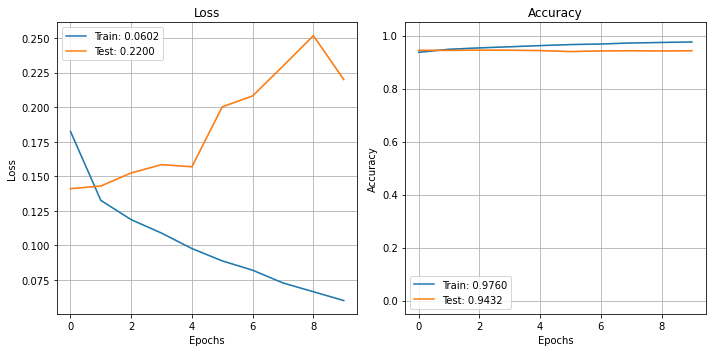

In [29]:
plot_history(history.history)

In [43]:
y_pred = model.predict(X_test)
y_pred_transform = np.argmax(y_pred, axis=1)

In [44]:
matrix = classification_report(y_test_transform.to_numpy(), y_pred_transform)
print(matrix)

              precision    recall  f1-score   support

           0       0.74      0.62      0.67       673
           1       0.97      0.98      0.97      7563

    accuracy                           0.95      8236
   macro avg       0.85      0.80      0.82      8236
weighted avg       0.95      0.95      0.95      8236



In [55]:
from keras.models import Sequential, save_model, load_model
filepath = r'/content/drive/My Drive/ISS/EBA5004/PLP Project/transform_model.hdf5'
save_model(model, filepath)

# Load the model
# model = load_model(filepath, compile = True)

# predictions = model.predict(samples_to_predict)
# print(predictions)

NotImplementedError: ignored

In [36]:
# Load the model
model = load_model(filepath, compile = True)

y_pred = model.predict(X_test)
matrix = classification_report(np.argmax(y_test_onehot, axis=1), np.argmax(y_pred, axis=1))
print(matrix)
# print(predictions)

              precision    recall  f1-score   support

           0       0.59      0.56      0.57       673
           1       0.37      0.61      0.46      1511
           2       0.93      0.81      0.87      7562

    accuracy                           0.77      9746
   macro avg       0.63      0.66      0.64      9746
weighted avg       0.82      0.77      0.78      9746



In [ ]:
y_pred = model.predict("i am happy")
# need process and tokenization